# Asymmetric reflections solution domain

In [4]:
import numpy as np
from scipy import optimize
import intersection 
import matplotlib.pyplot as plt

def phi(theta, M):
    out = optimize.fsolve(lambda x: fun(x,M,theta),0.01)
    out = np.append(out, optimize.fsolve(lambda x: fun(x,M,theta),np.pi/2))
    return out
def theta(x,M):
    out = 2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    out = np.arctan(out)
    return out
def fun(x,M,theta):
    f=np.tan(theta)-2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    return f
def fun2(x,M):
    theta=np.arctan(2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2))
    return theta
def thetaMax(M):
    phi=optimize.fmin(lambda x: -fun2(x,M),0.1)
    theta=fun2(phi,M)
    return theta

class state(object):
  def __init__(self,p=100000,M=1.5,T=300,R=287,phi=0,gamma=1.4):
    self.p=p
    self.M=M
    self.T=T
    self.gamma=gamma
    self.phi=phi
    self.R=R
    self.rho=self.p/(self.R*self.T)
    self.u=self.M*np.sqrt(self.gamma*self.R*self.T)
    
def oblique(state0,theta1=10*np.pi/180,weak='True'):
  #theta=theta
  p=phi(theta1,state0.M)
  tmax=thetaMax(state0.M)
  print("Theta max :",tmax*180/np.pi)
  if tmax<theta1:
        print("Shock detached")
  else:
    if weak=='True':
      ph=p[0]
    else:
      ph=p[1]
    M1=np.sqrt((1+(state0.gamma-1)*0.5*(state0.M*np.sin(ph))**2)/(state0.gamma*(state0.M*np.sin(ph))**2-(state0.gamma-1)*0.5))/(np.sin(ph-theta1))
    p2=state0.p*(1+2*state0.gamma*((state0.M*np.sin(ph))**2-1)/(1+state0.gamma))
    T2=state0.T*(p2/state0.p)*(2+(state0.gamma-1)*(state0.M*np.sin(ph))**2)/((1+state0.gamma)*(state0.M*np.sin(ph))**2)
    state1=state(M=M1,p=p2,T=T2)
    state1.phi = ph
    state1.theta= theta1
    return state1

def ST(state0,theta1):
  state1=oblique(state0,theta1=theta1)
  if theta1<thetaMax(state1.M):
        print("This case is a Regular reflection")
        print("Solving using 2 shock theory . . .")
        state2=oblique(state1,theta1=theta1)
        return state1,state2
  else:
    print("This case is a Mach reflection")
    print("Solving for the Standard solution using 3 shock theory...")
    phi = ThreeST(state0,state1,theta1)
    phi2 = phi[0]
    phi3 = phi[1]
    theta2 = theta(phi2,state1.M)
    print(theta2*180/np.pi)
    theta3 = theta(phi3,state0.M)
    state3 = oblique(state0,theta1=theta3)
    state3.phi = phi3
    state3.theta = theta3
    state2 = oblique(state1,theta1=theta2)
    state2.phi = phi2
    state2.theta =theta2
    return state1,state2,state3

def ThreeST(state0,state1,theta):
    p = np.array([[]])
    p = np.append(p,state0.M)  # M0
    p = np.append(p,state1.M)  # M1
    p = np.append(p,theta)  # theta
    p = np.append(p,state1.p/state0.p) # p1/p0
    return optimize.fsolve(lambda x: fun3(x,p),100*np.array([0.01,0.01]))
    
def fun3(x,p,gamma = 1.4):
    """
    x[0] - phi2
    x[1] - phi3
    """
    f=np.array([])
    f=np.append(f,(1+2*(p[1]**2*np.sin(x[0])**2-1)*gamma/(gamma+1))*p[3]-(1+2*(p[0]**2*np.sin(x[1])**2-1)*gamma/(gamma+1)))
    f=np.append(f,p[2]-theta(x[0],p[1])-theta(x[1],p[0]))
    return f
    
    
def polar(M0,both = 'True',type ='p', positive='True',gamma=1.4):
    tmax = thetaMax(M0)
    print("ThetaMax:", tmax*180/np.pi)
    theta = np.linspace(0,tmax,100)
    if type == 'p':
      pWeak = np.asarray([pRatio(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False') for k in theta])
    elif type == 'M':
      pWeak = np.asarray([Mj(k,M0) for k in theta])
      pStrong = np.asarray([Mj(k,M0,weak = 'False') for k in theta])
    elif type == 'rho':
      pWeak = np.asarray([rho(k,M0) for k in theta])
      pStrong = np.asarray([rho(k,M0,weak = 'False') for k in theta])
    elif type == 'T':
      pWeak = np.asarray([pRatio(k,M0)/rho(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False')/rho(k,M0,weak = 'False') for k in theta])  
    theta = np.append(theta,np.flipud(theta))
    p = np.append(pWeak,np.flipud(pStrong))
    if both =='True':
       p = np.append(p,np.flipud(p))
       theta = np.append(theta,np.flipud(-theta))
    return theta, p


def plot(theta,p,label):
    for k,j,m in zip(theta,p,label):
        plt.plot(theta[k]*180/np.pi,p[j],label=label[m])
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('theta')
    plt.savefig("DiamondFoil.eps", format='eps', dpi=1000)
    plt.show()
  
   
def Mj(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    Mj=np.sqrt((1+(gamma-1)*0.5*(M*np.sin(z))**2)/(gamma*(M*np.sin(z))**2-(gamma-1)*0.5))/(np.sin(z-x))
    return Mj

def rho(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    rho=((1+gamma)*(M*np.sin(z))**2)/(2+(gamma-1)*(M*np.sin(z))**2)
    return rho    
    
def pRatio(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    p = 1+2*gamma*((M*np.sin(z))**2-1)/(1+gamma)
    return p

def pRatioMax(M):
    return optimize.fmin(lambda x: -pRatio(x,M,gamma=1.4),0.1)

def nu(M,gamma=1.4):
    return np.sqrt((gamma+1)/(gamma-1))*np.arctan(np.sqrt((gamma-1)*(M**2-1)/(gamma+1)))-np.arctan(np.sqrt(M**2-1))

"""
def Mprandtl(nu0,gamma=1.4):
    return optimize.fmin(lambda x: nu0-nu(x),0.01)
"""

def M(nu):
    """
    obtained using Hall's approximation
    """
    nu0 = np.pi*0.5*(np.sqrt(6)-1)
    A = 1.3604
    B = 0.0962
    C = -0.5127
    D = -0.6722
    E = -0.3278
    y = (nu/nu0)**(2/3)
    return (1+A*y+B*y**2+C*y**3)/(1+D*y+E*y**2)

def pRatioIsen(M1,M2,gamma=1.4):
    return ((1+(gamma-1)*0.5*M1**2)/(1+(gamma-1)*0.5*M2**2))**(gamma/(gamma-1))

def polarIsen(M1, thetamax = 0,  gamma=1.4):
    nu1 = nu(M1)
    nu2max =  np.pi*0.5*(np.sqrt((gamma+1)/(gamma-1))-1)
    if thetamax == 0 :
        thetamax = nu2max-nu1
    theta = np.linspace(0,thetamax,100)    
    M2 = M(theta+nu1)
    p = pRatioIsen(M1, M2,gamma=gamma)
    theta = np.append(theta,np.flipud(theta))
    theta = np.append(theta,np.flipud(-theta))
    p = np.append(p,np.flipud(p))
    p = np.append(p,np.flipud(p))
    return theta,p

def Mprandtl(theta,M0):
    nu0=nu(M0)
    M1 = M(theta+nu0)
    return M1
    


In [20]:
def F(M,psi,gamma=1.4):
    out = np.arctan((((psi-1)**2*(2*gamma*(M**2-1)-(gamma+1)*(psi-1)))/((gamma*M**2-psi+1)**2*(2*gamma+(gamma+1)*(psi-1))))**0.5)
    return out

def G(M,psi,gamma=1.4):
    a1=4*gamma*(M**2-1)-(gamma+1)*(4-M**2)*(psi-1)-(gamma+1)*(psi-1)**2
    a2=(2*gamma*(M**2-1)-(gamma+1)*(psi-1))**0.5*(2*gamma+(gamma+1)*(psi-1))**0.5
    a3 = 2*gamma*M**2-(4-(gamma+1)*M**2)*(psi-1)-2*(psi-1)**2
    return a1/(a2*a3)

def detachmentFunc(M0,theta2,x):
    theta1 = x[0]
    p = x[1]
    #p2_ = x[2]
    M1=Mj(theta1,M0,gamma =1.4, weak = 'True')
    M2=Mj(theta2,M0,gamma =1.4, weak = 'True')
    p1=pRatio(theta1,M0,gamma =1.4, weak = 'True')
    p2=pRatio(theta2,M0,gamma =1.4, weak = 'True')
    out = np.array([100*(F(M1, p/p1)+F(M2,p/p2)+theta1-theta2),1000*(G(M1, p/p1)+G(M2,p/p2))])
    #out = np.array([F(M1, p1_)+F(M2,p2_)+theta1-theta2,G(M1, p1_)+G(M2,p2_)])
    return out

def vonNeumanFunc(M0,theta2,x):
    theta1 = x[0]
    p = x[1]
    M1=Mj(theta1,M0,gamma =1.4, weak = 'True')
    M2=Mj(theta2,M0,gamma =1.4, weak = 'True')
    p1=pRatio(theta1,M0,gamma =1.4, weak = 'True')
    p2=pRatio(theta2,M0,gamma =1.4, weak = 'True')
    out = np.array([1000*(F(M0, p)+F(M1,p/p1)+theta1),100*(F(M0, p)-F(M2,p/p2)+theta2)])
    return out

def asymmetric(M0):
    theta1 = np.linspace(0,thetaMax(M0),100)
    theta2D=np.array([])
    theta2N=np.array([])
    for t in theta1:
      out1 = optimize.fsolve(lambda x: detachmentFunc(M0,t,x),np.array([0.01,0.01]))
      theta2D= np.append(theta2D,out1[0])
      out1 = optimize.fsolve(lambda x: vonNeumanFunc(M0,t,x),np.array([0.01,0.01]))
      theta2N= np.append(theta2N,out1[0])
    return theta1, theta2D,theta2N

    

In [21]:
theta1, theta2D,theta2N =asymmetric(4.96)

Optimization terminated successfully.
         Current function value: -0.716433
         Iterations: 20
         Function evaluations: 40


C:\Users\sagar\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sagar\Anaconda3\lib\site-packages\ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in sqrt
C:\Users\sagar\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
C:\Users\sagar\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


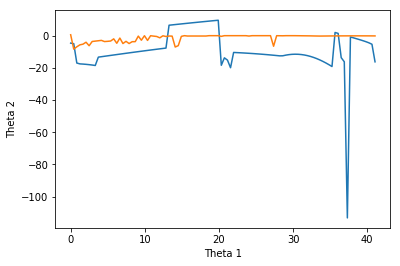

In [23]:
plt.plot(theta1*180/np.pi,theta2D*180/np.pi)
plt.plot(theta1*180/np.pi,theta2N*180/np.pi)
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.savefig('asymmetricDomain.eps')
plt.show()